<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Leitura-dos-dados-de-chamadas" data-toc-modified-id="Leitura-dos-dados-de-chamadas-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Leitura dos dados de chamadas</a></span><ul class="toc-item"><li><span><a href="#Coluna-1:-faixa-de-hora-no-dia" data-toc-modified-id="Coluna-1:-faixa-de-hora-no-dia-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Coluna 1: faixa de hora no dia</a></span></li><li><span><a href="#Coluna-2:-tipo-de-dia" data-toc-modified-id="Coluna-2:-tipo-de-dia-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Coluna 2: tipo de dia</a></span></li><li><span><a href="#Coluna-3:-bairro" data-toc-modified-id="Coluna-3:-bairro-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Coluna 3: bairro</a></span></li><li><span><a href="#Coluna-4:-prioridade-da-chamada" data-toc-modified-id="Coluna-4:-prioridade-da-chamada-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Coluna 4: prioridade da chamada</a></span></li><li><span><a href="#Coluna-5:-ocorrência" data-toc-modified-id="Coluna-5:-ocorrência-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Coluna 5: ocorrência</a></span></li></ul></li><li><span><a href="#Criar-classe-do-modelo" data-toc-modified-id="Criar-classe-do-modelo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Criar classe do modelo</a></span></li><li><span><a href="#Treinar-por-100-epochs" data-toc-modified-id="Treinar-por-100-epochs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Treinar por 100 epochs</a></span></li><li><span><a href="#Avaliar-evolução-dos-parâmetros" data-toc-modified-id="Avaliar-evolução-dos-parâmetros-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Avaliar evolução dos parâmetros</a></span></li></ul></div>

In [1]:
import sys
import torch
import numpy as np  

from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable

import matplotlib.pyplot as plt

In [2]:
sys.path.append('../../..')
from config import *
from utils import *

# Leitura dos dados

In [3]:
df = pd.read_pickle(os.path.join(TRTD_DATA_PATH,'eventos.pkl'))
df.head()

,data_idx,Prioridade,TotalViaturas,latitude,longitude,data,hora,p,Coordenadas,g,lat,lon,geometry,i,nome_bairro,t
1,2016-01-01 02:13:00,0,1,-22.876186,-43.675890,2016-01-01,2:13:05,1,POINT (-43.67589 -22.876186),1,-43.675890,-22.876186,POINT (-43.67589 -22.87619),149,Santa Cruz,5
3,2016-01-01 02:17:00,1,1,-22.906627,-43.293335,2016-01-01,2:17:06,2,POINT (-43.293335 -22.906627),1,-43.293335,-22.906627,POINT (-43.29333 -22.90663),66,Engenho De Dentro,5
6,2016-01-01 02:28:00,0,1,-23.012424,-43.541721,2016-01-01,2:28:08,1,POINT (-43.541721 -23.012424),1,-43.541721,-23.012424,POINT (-43.54172 -23.01242),152,Barra De Guaratiba,5
15,2016-01-01 02:51:00,0,2,-22.851838,-43.357152,2016-01-01,2:51:25,1,POINT (-43.357152 -22.851838),1,-43.357152,-22.851838,POINT (-43.35715 -22.85184),87,Honório Gurgel,6
20,2016-01-01 03:00:00,0,1,-22.824990,-43.392745,2016-01-01,3:00:47,1,POINT (-43.392745 -22.82499),1,-43.392745,-22.824990,POINT (-43.39274 -22.82499),107,Anchieta,7


In [4]:
vizinhancas = pd.read_csv(os.path.join(ENTR_DATA_PATH,'bairros_vizinhos.csv'),sep=';',encoding='latin-1',index_col=0)
vizinhancas.head()

,NOME,NEIGHBORS
0,Paquetá,NaN
1,Freguesia,Bancários
2,Bancários,"Freguesia, Tauá, Cocotá"
3,Galeão,"Portuguesa, Jardim Guanabara, Cidade Universit..."
4,Tauá,"Bancários, Moneró, Cocotá, Jardim Carioca"


# Tratamentos

In [5]:
# dropar paquetá
vizinhancas.drop(0,inplace=True)
df = df[df['i']!=0]

In [6]:
bairro_to_idx = df[['i','nome_bairro']].drop_duplicates().set_index('nome_bairro')['i'].to_dict()

vizinhancas['NOME'] = vizinhancas['NOME'].map(bairro_to_idx)
bairro_to_vizinhos = vizinhancas.set_index('NOME')['NEIGHBORS'].apply(lambda v:[bairro_to_idx[b.strip()] for b in v.split(',')]).to_dict()

In [7]:
idx_to_i = {idx:i for (i,idx) in enumerate(bairro_to_vizinhos.keys())}
i_to_idx = {i:idx for (i,idx) in enumerate(bairro_to_vizinhos.keys())}

In [8]:
N_BAIRROS = len(bairro_to_idx)

# Criar classe do modelo

In [9]:
p = 1
g = 1
t = 24

Y = np.zeros(shape=(N_BAIRROS,522))

for bairro,idx in tqdm(list(bairro_to_idx.items())):
    i = idx_to_i[idx]
    Y[i,:] = calcular_distribuicao(df,t,g,idx,p,tipo_discretizacao_temp=0)

100%|██████████| 159/159 [01:58<00:00,  1.34it/s]


In [10]:
class ModelWithNoRegressors(nn.Module):
    def __init__(self,n,alpha_=.3,eps=1e-8):
        super(ModelWithNoRegressors, self).__init__()
        
        self.alpha = alpha_
        self.eps = eps
        self.params_hist = []
        
        self.linear1   = nn.Linear(1, n, bias=False)
        self.optimizer = optim.SGD(self.parameters(), lr=0.01)
        
        self.linear1.weight.data.fill_(eps)

    def forward(self,state=np.ones(1)):
        x = self.linear1(torch.from_numpy(state).float())
        x = F.relu(x) + self.eps
        return torch.max(x,self.eps*torch.ones(len(x)))
        return x
    
    def backward(self,Y: np.array,lambdas):
        
        L = self.forward().detach()
        self.params_hist.append(L.numpy())
        
        Y = torch.tensor(Y)

        gradients = []
        for i,(eventos_bairro,l) in tqdm(enumerate(zip(Y,lambdas)),desc='Running backward',total=N_BAIRROS): #for Y, it assumes you're iterating collumns
            g = []
            idx = i_to_idx[i]
            # loop in j
            for y in eventos_bairro:
                verossimilhanca = l - y*torch.log(l)
                g.append(verossimilhanca)

            # termo regularizador
            vizinhos = bairro_to_vizinhos[idx]
            for vizinho_idx in vizinhos:
                vizinho_i = idx_to_i[vizinho_idx]
                vizinho_lambda = L[vizinho_i]
                reg = F.mse_loss(l,vizinho_lambda)*self.alpha

                g.append(reg.to(torch.float64))
                
            gradients.append(torch.stack(g).sum())
            
        self.optimizer.zero_grad()
        grad = torch.stack(gradients).sum()
        grad.backward()
        self.optimizer.step()

In [14]:
model = ModelWithNoRegressors(N_BAIRROS,.3)

In [15]:
n_epochs = 10
for _ in tqdm(range(n_epochs)):
    lambdas = model.forward()
    model.backward(Y,lambdas)

100%|██████████| 10/10 [01:37<00:00,  9.78s/it]


In [21]:
model.forward()

tensor([1.4513e+06, 6.6073e+05, 6.3573e+06, 2.9172e+06, 2.5842e+06, 1.0000e-08,
        3.0417e+07, 3.9726e+06, 1.0000e-08, 3.8852e+06, 1.5972e+06, 4.9127e+06,
        6.2503e+06, 3.4331e+06, 4.3796e+06, 1.7727e+06, 1.0000e-08, 7.2900e+06,
        2.1998e+07, 1.6970e+06, 8.8977e+06, 6.1766e+06, 2.2622e+06, 5.1769e+05,
        1.0000e-08, 7.2790e+06, 8.6858e+06, 1.0000e-08, 1.0000e-08, 6.0091e+06,
        6.4728e+06, 3.2124e+06, 3.4845e+06, 2.2747e+06, 3.5044e+06, 1.0000e-08,
        4.0468e+06, 6.3183e+06, 5.5318e+06, 5.5950e+06, 2.9328e+06, 2.4246e+06,
        6.7503e+06, 6.7226e+06, 1.7804e+07, 4.1392e+06, 6.1335e+06, 5.0459e+06,
        1.2971e+07, 2.6075e+06, 4.2836e+06, 3.7908e+06, 7.6766e+06, 9.2972e+06,
        3.7695e+06, 5.9991e+06, 5.5060e+06, 3.2369e+06, 5.6534e+06, 1.0320e+07,
        5.1451e+06, 2.2175e+07, 3.8696e+06, 1.0346e+07, 3.8155e+06, 2.5936e+06,
        2.9367e+06, 3.0552e+06, 1.0000e-08, 3.5611e+06, 2.7582e+06, 4.8764e+06,
        6.5109e+06, 4.4099e+06, 2.5879e+

# Avaliar evolução dos parâmetros

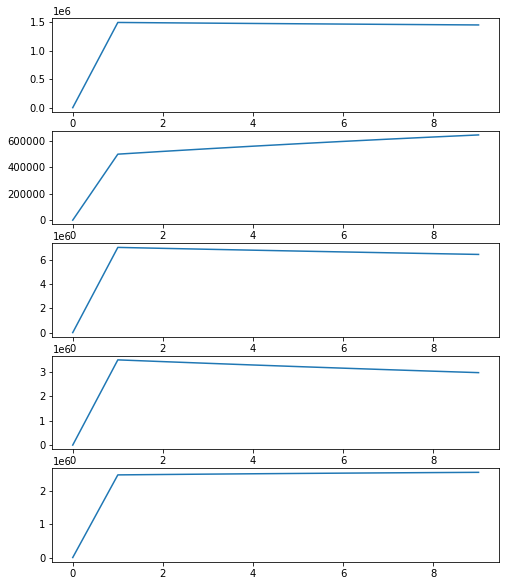

In [20]:
fig,axes = plt.subplots(nrows=5,ncols=1,figsize=(8,10))

for i,p in enumerate(np.array(model.params_hist).transpose()):
    try:
        axes[i].plot(p)
    except:
        break